In [1]:
# 📌 Cell 1: Import Required Libraries

# Data handling
import pandas as pd
import numpy as np

# Machine learning (scikit-learn)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score

# Visualization
import matplotlib.pyplot as plt

# To make plots look nicer
plt.style.use("seaborn-v0_8")


In [2]:
# Load and Explore the Mushroom Dataset

# Load dataset (make sure mushrooms.csv is in the same folder as your notebook)
df = pd.read_csv("mushrooms.csv")

# Display the first 5 rows
print(" First 5 rows of the dataset:")
print(df.head())

# Dataset shape (rows, columns)
print("\n Dataset shape (rows, columns):", df.shape)

# Target variable distribution (class column: 'e' = edible, 'p' = poisonous)
print("\n Target class distribution:")
print(df['class'].value_counts())

# Check for missing values
print("\nMissing values in each column:")
print(df.isnull().sum())


 First 5 rows of the dataset:
  class cap-shape cap-surface cap-color bruises odor gill-attachment  \
0     p         x           s         n       t    p               f   
1     e         x           s         y       t    a               f   
2     e         b           s         w       t    l               f   
3     p         x           y         w       t    p               f   
4     e         x           s         g       f    n               f   

  gill-spacing gill-size gill-color  ... stalk-surface-below-ring  \
0            c         n          k  ...                        s   
1            c         b          k  ...                        s   
2            c         b          n  ...                        s   
3            c         n          n  ...                        s   
4            w         b          k  ...                        s   

  stalk-color-above-ring stalk-color-below-ring veil-type veil-color  \
0                      w                      w   

In [3]:
# Cell 3: Split the Dataset into Training and Testing Sets

# Separate features (X) and target (y)
X = df.drop(columns=['class'])
y = df['class']

# Split into 80% train and 20% test, keeping class balance
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

# Show the sizes of the splits
print("Training set size:", X_train.shape[0])
print("Testing set size:", X_test.shape[0])

# Verify class balance in both sets
print("\nClass distribution in training set:")
print(y_train.value_counts(normalize=True))

print("\nClass distribution in testing set:")
print(y_test.value_counts(normalize=True))


Training set size: 6499
Testing set size: 1625

Class distribution in training set:
class
e    0.517926
p    0.482074
Name: proportion, dtype: float64

Class distribution in testing set:
class
e    0.518154
p    0.481846
Name: proportion, dtype: float64


In [4]:
# Cell 4: Build and Train the Naïve Bayes Classifier

# Create a pipeline: OneHotEncoder -> MultinomialNB
pipeline = make_pipeline(
    OneHotEncoder(handle_unknown='ignore'),
    MultinomialNB()
)

# Train the model
pipeline.fit(X_train, y_train)

print("Naïve Bayes model has been trained successfully.")


Naïve Bayes model has been trained successfully.


Classification Report:
              precision    recall  f1-score   support

           e     0.9116    0.9917    0.9499       842
           p     0.9901    0.8966    0.9410       783

    accuracy                         0.9458      1625
   macro avg     0.9508    0.9441    0.9455      1625
weighted avg     0.9494    0.9458    0.9456      1625

Accuracy: 0.9458461538461539


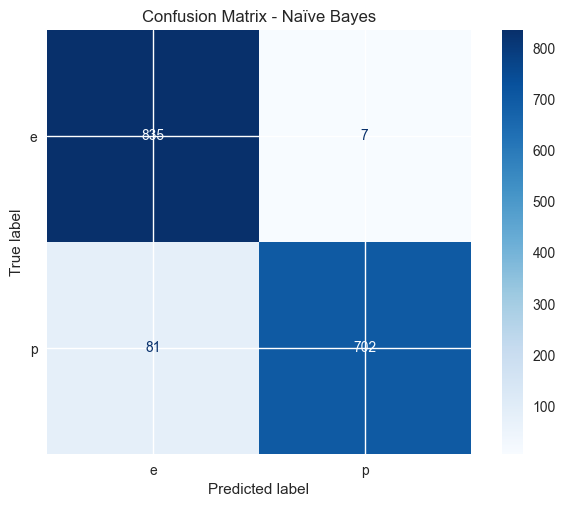

In [5]:
# Cell 5: Evaluate the Naïve Bayes Classifier

# Make predictions on the test set
y_pred = pipeline.predict(X_test)

# Print classification report (precision, recall, F1-score)
print("Classification Report:")
print(classification_report(y_test, y_pred, digits=4))

# Print overall accuracy
print("Accuracy:", accuracy_score(y_test, y_pred))

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=pipeline.classes_)

# Display confusion matrix as a plot
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipeline.classes_)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - Naïve Bayes")
plt.show()
